In [1]:
import pandas as pd
import numpy as np

import rasterio
from skimage.transform import resize
from skimage.transform import rotate
import os

import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error

from sklearn.model_selection import train_test_split

from datetime import timedelta
from skimage.draw import polygon
import matplotlib.pyplot as plt

from shapely.geometry import Polygon

from utils import process_yield_data
from pathlib import Path

import matplotlib.pyplot as plt

#### Import Yield Data

In [2]:
YIELD_DATA_PATH = Path("./combined_yield_data.csv")
yield_data_weekly = process_yield_data(YIELD_DATA_PATH)

            Volume (Pounds)  Cumulative Volumne (Pounds)  Pounds/Acre
Date                                                                 
2012-01-02          23400.0                      23400.0          2.0
2012-01-03          26064.0                      49464.0          3.0
2012-01-04          32382.0                      81846.0          3.0
2012-01-05          69804.0                     151650.0          7.0
2012-01-06          18000.0                     169650.0          2.0

Number of Yield Data Points:  3970

Column Names: Index(['Volume (Pounds)', 'Cumulative Volumne (Pounds)', 'Pounds/Acre'], dtype='object')
Number of Yield Data Points: 2879
Yield data with time features:
            Volume (Pounds)  Cumulative Volumne (Pounds)  Pounds/Acre  \
Date                                                                    
2012-03-04         525753.0                    1785843.0    18.333333   
2012-03-11        2949534.0                    4735377.0    51.666667   
2012-03-18   

#### Define the Model

In [3]:
target_shape = (512, 512)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device} device")

Using mps device


### New Model

In [4]:
class CNNFeatureExtractor(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(CNNFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.flattened_size = self._get_conv_output((1, 512, 512))
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.dropout = nn.Dropout(dropout_rate)

    def _get_conv_output(self, shape):
        x = torch.rand(1, *shape)
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        n_size = x.view(1, -1).size(1)
        return n_size

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, self.flattened_size)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return x

class HybridModel(nn.Module):
    def __init__(self, cnn_feature_extractor, lstm_hidden_size=16, lstm_layers=1, dropout_rate=0.6):
        super(HybridModel, self).__init__()
        self.cnn = cnn_feature_extractor
        self.lstm = nn.LSTM(input_size=64, hidden_size=lstm_hidden_size, num_layers=lstm_layers, batch_first=True)
        self.fc1 = nn.Linear(lstm_hidden_size + 4, 32)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(32, 512 * 512)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.target_shape = (512, 512)

    def forward(self, x, time_features):
        batch_size, time_steps, C, H, W = x.size()
        c_in = x.view(batch_size * time_steps, C, H, W)
        c_out = self.cnn(c_in)
        r_in = c_out.view(batch_size, time_steps, -1)
        r_out, (h_n, c_n) = self.lstm(r_in)
        r_out = r_out[:, -1, :]
        x = torch.cat((r_out, time_features), dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = x.view(batch_size, *self.target_shape)
        return x

#### Initialize Function

In [5]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

batch_size = 16
epochs = 50

### Functions for prediction

In [6]:
from inference_utils import (
    preprocess_image,
    compute_mean_std,
    load_evi_data_and_prepare_features,
    find_closest_date,
    find_closest_date_in_df,
    mask_evi_data,
    predict,
    predict_weekly_yield,
    augment_image,
    prepare_dataset,
    train_and_evaluate,
    sync_evi_yield_data,
    CustomDataset,
    load_evi_data,
    find_common_date_range
)


In [7]:
# Load EVI data and prepare time features, including the dataset
evi_data_dir = "./landsat_evi_monterey_masked"
train_loader, val_loader, mean, std, dataset = prepare_dataset(evi_data_dir, yield_data_weekly, target_shape, augment=True)

Processed file 1/84 in 1.77s
Processed file 2/84 in 2.24s
Processed file 3/84 in 1.97s
Processed file 4/84 in 2.07s
Processed file 5/84 in 2.19s
Processed file 6/84 in 2.12s
Processed file 7/84 in 1.85s
Processed file 8/84 in 2.10s
Processed file 9/84 in 1.79s
Processed file 10/84 in 1.93s
Processed file 11/84 in 2.18s
Processed file 12/84 in 2.11s
Processed file 13/84 in 2.14s
Processed file 14/84 in 2.14s
Processed file 15/84 in 1.89s
Processed file 16/84 in 1.83s
Processed file 17/84 in 1.83s
Processed file 19/84 in 2.20s
Processed file 20/84 in 2.28s
Processed file 21/84 in 1.86s
Processed file 22/84 in 1.96s
Processed file 23/84 in 1.90s
Processed file 24/84 in 1.72s
Processed file 25/84 in 1.88s
Processed file 26/84 in 1.73s
Processed file 27/84 in 2.01s
Processed file 28/84 in 1.68s
Processed file 29/84 in 1.81s
Processed file 30/84 in 2.09s
Processed file 31/84 in 2.14s
Processed file 32/84 in 2.15s
Processed file 33/84 in 1.79s
Processed file 34/84 in 2.23s
Processed file 35/8

### Model Evaluation (Cross Validation)

In [8]:
# Initialize TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

mse_scores = []
rmse_scores = []
mae_scores = []
r2_scores = []
medae_scores = []

# Lists to store losses for plotting
all_train_losses = []
all_val_losses = []

epochs = 50
patience = 5 
early_stop = False

# Cross-validation with train_and_evaluate
for fold, (train_index, val_index) in enumerate(tscv.split(yield_data_weekly)):
    print(f"Fold {fold + 1}")

    # Check if indices are within bounds
    if max(train_index) >= len(dataset) or max(val_index) >= len(dataset):
        print(f"Error: Indices out of range for fold {fold + 1}")
        continue 

    # Create Subsets for the current fold
    fold_train_subset = torch.utils.data.Subset(dataset, train_index)
    fold_val_subset = torch.utils.data.Subset(dataset, val_index)

    # DataLoaders for the current fold
    fold_train_loader = DataLoader(fold_train_subset, batch_size=batch_size, shuffle=True)
    fold_val_loader = DataLoader(fold_val_subset, batch_size=batch_size, shuffle=False)

    # Instantiate a new model for each fold
    model = HybridModel(CNNFeatureExtractor())
    model.apply(weights_init)
    model.to(device)

    # Set up the optimizer, scheduler, and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    criterion = nn.MSELoss()

    # Train and evaluate the model using the function
    val_loss, train_losses, val_losses, val_mse, val_rmse, val_mae, val_medae, val_r2 = train_and_evaluate(
        model, fold_train_loader, fold_val_loader, optimizer, scheduler, criterion, epochs, device
    )
    
    # Store the train and val losses for visualization
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)

    # Model evaluation on the validation set
    model.eval()
    with torch.no_grad():
        outputs_val = []
        labels_val = []
        for evi_batch, label_batch, time_features_batch, timestamp in fold_val_loader:
            evi_batch, label_batch, time_features_batch = evi_batch.to(device), label_batch.to(device), time_features_batch.to(device)
            outputs_batch = model(evi_batch, time_features_batch) # lbs/pixel
            outputs_val.extend(outputs_batch.cpu().numpy().flatten())
            label_batch = label_batch.unsqueeze(1).unsqueeze(2).expand(-1, target_shape[0], target_shape[1])
            labels_val.extend(label_batch.cpu().numpy().flatten())

    # Flatten the outputs and labels
    outputs_val = np.array(outputs_val)
    labels_val = np.array(labels_val)

    # Calculate val metrics
    mse = mean_squared_error(labels_val, outputs_val)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(labels_val, outputs_val)
    r2 = r2_score(labels_val, outputs_val)
    medae = median_absolute_error(labels_val, outputs_val)

    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    medae_scores.append(medae)

# Print results
print(f"Average MSE: {np.mean(mse_scores)}")
print(f"Average RMSE: {np.mean(rmse_scores)}")
print(f"Average MAE: {np.mean(mae_scores)}")
print(f"Average MedAE: {np.mean(medae_scores)}")
print(f"Average R-squared: {np.mean(r2_scores)}")

Fold 1
# of samples - Training   - 111
# of samples - Validation - 106


  0%|          | 0/7 [00:00<?, ?it/s]/Users/cameron/Documents/GitHub/AgriSense-210-Capstone/train_model/inference_utils.py:53: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  evi_sequence = torch.tensor(evi_sequence, dtype=torch.float32).unsqueeze(1)
100%|██████████| 7/7 [00:24<00:00,  3.53s/it]


Epoch 1, Loss: 14.589914049421038


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.6025696567126683


100%|██████████| 7/7 [00:24<00:00,  3.52s/it]


Epoch 2, Loss: 10.535046577453613


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.4011320642062596


100%|██████████| 7/7 [00:24<00:00,  3.53s/it]


Epoch 3, Loss: 8.8575758934021


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.3429240435361862


100%|██████████| 7/7 [00:25<00:00,  3.63s/it]


Epoch 4, Loss: 7.697858537946429


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.2614275025469916


100%|██████████| 7/7 [00:24<00:00,  3.57s/it]


Epoch 5, Loss: 6.056733131408691


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.21036713783230102


100%|██████████| 7/7 [00:24<00:00,  3.52s/it]


Epoch 6, Loss: 5.08947661944798


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.17893601741109574


100%|██████████| 7/7 [00:24<00:00,  3.52s/it]


Epoch 7, Loss: 4.299776077270508


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.16147997123854502


100%|██████████| 7/7 [00:24<00:00,  3.54s/it]


Epoch 8, Loss: 3.9307054110935757


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.149993539920875


100%|██████████| 7/7 [00:24<00:00,  3.53s/it]


Epoch 9, Loss: 3.4157393319266185


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14334395421402796


100%|██████████| 7/7 [00:24<00:00,  3.55s/it]


Epoch 10, Loss: 2.9932406970432828


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1371882344995226


100%|██████████| 7/7 [00:24<00:00,  3.53s/it]


Epoch 11, Loss: 2.878439392362322


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.12682845390268735


100%|██████████| 7/7 [00:24<00:00,  3.56s/it]


Epoch 12, Loss: 2.537508027894156


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11349127069115639


100%|██████████| 7/7 [00:24<00:00,  3.56s/it]


Epoch 13, Loss: 2.482109580721174


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11081355437636375


100%|██████████| 7/7 [00:24<00:00,  3.55s/it]


Epoch 14, Loss: 2.1797217300959995


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.10839198662766389


100%|██████████| 7/7 [00:24<00:00,  3.57s/it]


Epoch 15, Loss: 1.7500627551759993


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1062606330960989


100%|██████████| 7/7 [00:24<00:00,  3.56s/it]


Epoch 16, Loss: 1.6881361518587386


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.10440875696284431


100%|██████████| 7/7 [00:25<00:00,  3.61s/it]


Epoch 17, Loss: 1.449367983000619


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.10276585764118604


100%|██████████| 7/7 [00:24<00:00,  3.56s/it]


Epoch 18, Loss: 1.3020603145871843


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.10133723382438932


100%|██████████| 7/7 [00:25<00:00,  3.60s/it]


Epoch 19, Loss: 1.2974998440061296


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09999343646424157


100%|██████████| 7/7 [00:24<00:00,  3.53s/it]


Epoch 20, Loss: 1.0199010797909327


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.0987999045423099


100%|██████████| 7/7 [00:24<00:00,  3.49s/it]


Epoch 21, Loss: 0.9876366598265511


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09775257855653763


100%|██████████| 7/7 [00:24<00:00,  3.51s/it]


Epoch 22, Loss: 0.886288583278656


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09679530414619616


100%|██████████| 7/7 [00:24<00:00,  3.43s/it]


Epoch 23, Loss: 0.8812462772641864


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09589327525879655


100%|██████████| 7/7 [00:24<00:00,  3.52s/it]


Epoch 24, Loss: 0.8353471245084491


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09503341572625297


100%|██████████| 7/7 [00:24<00:00,  3.52s/it]


Epoch 25, Loss: 0.7022737264633179


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.0942905843257904


100%|██████████| 7/7 [00:24<00:00,  3.45s/it]


Epoch 26, Loss: 0.7248713544436863


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09359683921294552


100%|██████████| 7/7 [00:24<00:00,  3.47s/it]


Epoch 27, Loss: 0.6442887527602059


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09299892745912075


100%|██████████| 7/7 [00:24<00:00,  3.44s/it]


Epoch 28, Loss: 0.6066233388015202


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09246160595544747


100%|██████████| 7/7 [00:24<00:00,  3.47s/it]


Epoch 29, Loss: 0.5480344252926963


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09194973616727761


100%|██████████| 7/7 [00:24<00:00,  3.44s/it]


Epoch 30, Loss: 0.48433678490774973


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09148028492927551


100%|██████████| 7/7 [00:23<00:00,  3.43s/it]


Epoch 31, Loss: 0.49893099069595337


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09107736684381962


100%|██████████| 7/7 [00:24<00:00,  3.45s/it]


Epoch 32, Loss: 0.4621809295245579


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09071167345557894


100%|██████████| 7/7 [00:24<00:00,  3.44s/it]


Epoch 33, Loss: 0.48749934349741253


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09037233090826444


100%|██████████| 7/7 [00:24<00:00,  3.46s/it]


Epoch 34, Loss: 0.43005890931401936


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09005600426878248


100%|██████████| 7/7 [00:24<00:00,  3.46s/it]


Epoch 35, Loss: 0.4068834228175027


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08977853506803513


100%|██████████| 7/7 [00:24<00:00,  3.45s/it]


Epoch 36, Loss: 0.4465213971478598


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08951446586953742


100%|██████████| 7/7 [00:24<00:00,  3.46s/it]


Epoch 37, Loss: 0.3300302156380245


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08926865731232933


100%|██████████| 7/7 [00:24<00:00,  3.45s/it]


Epoch 38, Loss: 0.34856083137648447


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08903868256935052


100%|██████████| 7/7 [00:24<00:00,  3.47s/it]


Epoch 39, Loss: 0.30938776050295147


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08883337636611291


100%|██████████| 7/7 [00:24<00:00,  3.48s/it]


Epoch 40, Loss: 0.3109051670346941


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08863456234601992


100%|██████████| 7/7 [00:24<00:00,  3.43s/it]


Epoch 41, Loss: 0.34778471078191486


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08845349201666457


100%|██████████| 7/7 [00:24<00:00,  3.47s/it]


Epoch 42, Loss: 0.2644759586879185


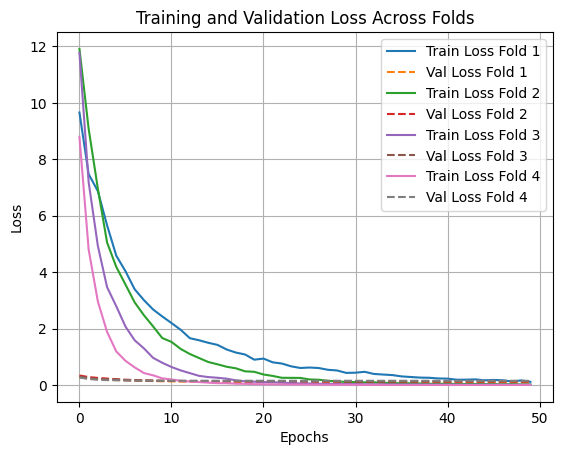

In [ ]:
for fold, (train_losses, val_losses) in enumerate(zip(all_train_losses, all_val_losses)):
    plt.plot(train_losses, label=f'Train Loss Fold {fold + 1}')
    plt.plot(val_losses, label=f'Val Loss Fold {fold + 1}', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Folds')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Print results
print(f"Average MSE: {np.mean(mse_scores)}")
print(f"Average RMSE: {np.mean(rmse_scores)}")
print(f"Average MAE: {np.mean(mae_scores)}")
print(f"Average MedAE: {np.mean(medae_scores)}")
print(f"Average R-squared: {np.mean(r2_scores)}")

Average MSE: 0.12171833217144012
Average RMSE: 0.3472882807254791
Average MAE: 0.25231698155403137
Average MedAE: 0.2555117607116699
Average R-squared: -1.091074620183182


# Train on full dataset

In [37]:
# Instantiate model
model = HybridModel(CNNFeatureExtractor())
model.apply(weights_init)
model.to(device)

# Set up the optimizer, scheduler, and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.MSELoss()

# Train and evaluate the model
val_loss = train_and_evaluate(model, train_loader, val_loader, optimizer, scheduler, criterion, epochs, device)

torch.save(model.state_dict(), "./trained-full-dataset-yield-density-no-leakage.pt")


# of samples - Training   - 439
# of samples - Validation - 110


100%|██████████| 110/110 [00:36<00:00,  3.02it/s]


Epoch 1, Loss: 7.093217336047779


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14377456504319394


100%|██████████| 110/110 [00:36<00:00,  3.01it/s]


Epoch 2, Loss: 1.9568945109844207


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11816590492214475


100%|██████████| 110/110 [00:36<00:00,  3.00it/s]


Epoch 3, Loss: 0.7911783399907025


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.10211560479365289


100%|██████████| 110/110 [00:36<00:00,  3.01it/s]


Epoch 4, Loss: 0.402532724020156


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09639275423251092


100%|██████████| 110/110 [00:36<00:00,  3.00it/s]


Epoch 5, Loss: 0.1960139024156061


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09374295673998338


100%|██████████| 110/110 [00:36<00:00,  3.00it/s]


Epoch 6, Loss: 0.09436337579549714


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09260952674750504


100%|██████████| 110/110 [00:36<00:00,  3.01it/s]


Epoch 7, Loss: 0.05326359465040944


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09209135050852117


100%|██████████| 110/110 [00:36<00:00,  3.00it/s]


Epoch 8, Loss: 0.028128187515010887


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09179116828350484


100%|██████████| 110/110 [00:36<00:00,  3.01it/s]


Epoch 9, Loss: 0.014267808012664317


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09164400660249937


100%|██████████| 110/110 [00:36<00:00,  3.01it/s]


Epoch 10, Loss: 0.008753123742909255


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09155200419627363


100%|██████████| 110/110 [00:36<00:00,  3.00it/s]


Epoch 11, Loss: 0.005025790067156777


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09150194022134071


100%|██████████| 110/110 [00:36<00:00,  3.00it/s]


Epoch 12, Loss: 0.0026419547897107393


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09147276628547323


100%|██████████| 110/110 [00:36<00:00,  2.99it/s]


Epoch 13, Loss: 0.0014318386304446242


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09145665311396962


100%|██████████| 110/110 [00:36<00:00,  3.03it/s]


Epoch 14, Loss: 0.0007602893092222406


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09144859839482576


100%|██████████| 110/110 [00:36<00:00,  3.03it/s]


Epoch 15, Loss: 0.00043805291795499877


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09144400912366889


100%|██████████| 110/110 [00:36<00:00,  3.03it/s]


Epoch 16, Loss: 0.00022044220396227584


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.0914415587337284


100%|██████████| 110/110 [00:36<00:00,  3.03it/s]


Epoch 17, Loss: 0.00011725157908751333


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09144026243840082


100%|██████████| 110/110 [00:36<00:00,  3.03it/s]


Epoch 18, Loss: 5.729070600698999e-05


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09143951148979974


100%|██████████| 110/110 [00:36<00:00,  3.04it/s]


Epoch 19, Loss: 3.087938086371816e-05


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09143914469282574


100%|██████████| 110/110 [00:36<00:00,  3.04it/s]


Epoch 20, Loss: 1.4760307272932881e-05


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09143893947357741


100%|██████████| 110/110 [00:36<00:00,  3.05it/s]


Epoch 21, Loss: 8.114327146234824e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09143883693735384


100%|██████████| 110/110 [00:36<00:00,  3.05it/s]


Epoch 22, Loss: 3.953565876393193e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09143878192971146


100%|██████████| 110/110 [00:35<00:00,  3.06it/s]


Epoch 23, Loss: 1.7218087685157776e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09143876331931024


100%|██████████| 110/110 [00:36<00:00,  3.05it/s]


Epoch 24, Loss: 8.69391119418982e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09143874171161791


100%|██████████| 110/110 [00:36<00:00,  3.05it/s]


Epoch 25, Loss: 4.4285870569896444e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09143873617317136


100%|██████████| 110/110 [00:36<00:00,  3.06it/s]


Epoch 26, Loss: 1.8600698461894312e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09143872583151891


100%|██████████| 110/110 [00:37<00:00,  2.92it/s]


Epoch 27, Loss: 8.406413417089647e-08


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09143872100854684


100%|██████████| 110/110 [00:37<00:00,  2.94it/s]


Epoch 28, Loss: 4.130064515434578e-08


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09143871747378725


100%|██████████| 110/110 [00:37<00:00,  2.95it/s]


Epoch 29, Loss: 1.4932575182429793e-08


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.0914387133939633


100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


Epoch 30, Loss: 6.977403194108334e-09


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.0914387195418792


100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


Epoch 31, Loss: 2.8666681276242915e-09


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09143872195052534


100%|██████████| 110/110 [00:37<00:00,  2.95it/s]


Epoch 32, Loss: 1.0752114821594388e-09


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09143871132227921


100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


Epoch 33, Loss: 4.1031306878042634e-10


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09143871157960749


100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


Epoch 34, Loss: 1.685373244688951e-10


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09143871782425579


100%|██████████| 110/110 [00:37<00:00,  2.95it/s]


Epoch 35, Loss: 5.7770965654914537e-11


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09143871576196595


100%|██████████| 110/110 [00:37<00:00,  2.94it/s]


Epoch 36, Loss: 2.176716552821695e-11


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09143871144625813


100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


Epoch 37, Loss: 8.463794633683727e-12
Validation Loss: 0.09143871694271535
Early stopping!


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Final Validation Set Metrics - MSE: 0.09225183725357056, RMSE: 0.3037298619747162, MAE: 0.2102953940629959, MedAE: 0.17406561970710754, R-squared: -0.9208154559243864


### Experimental Model 1

In [38]:
class CNNFeatureExtractor(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(CNNFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.flattened_size = self._get_conv_output((1, 512, 512))
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.dropout = nn.Dropout(dropout_rate)

    def _get_conv_output(self, shape):
        x = torch.rand(1, *shape)
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        n_size = x.view(1, -1).size(1)
        return n_size

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, self.flattened_size)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return x

class HybridModel(nn.Module):
    def __init__(self, cnn_feature_extractor, lstm_hidden_size=16, lstm_layers=1, dropout_rate=0.6):
        super(HybridModel, self).__init__()
        self.cnn = cnn_feature_extractor
        self.lstm = nn.LSTM(input_size=64, hidden_size=lstm_hidden_size, num_layers=lstm_layers, batch_first=True)
        self.fc1 = nn.Linear(lstm_hidden_size + 4, 32)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(32, 512 * 512)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.target_shape = (512, 512)

    def forward(self, x, time_features):
        batch_size, time_steps, C, H, W = x.size()
        c_in = x.view(batch_size * time_steps, C, H, W)
        c_out = self.cnn(c_in)
        r_in = c_out.view(batch_size, time_steps, -1)
        r_out, (h_n, c_n) = self.lstm(r_in)
        r_out = r_out[:, -1, :]
        x = torch.cat((r_out, time_features), dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = x.view(batch_size, *self.target_shape)
        return x

In [39]:
epochs = 50

# Instantiate model
simplified_cnn = CNNFeatureExtractor(dropout_rate=0.5)
model = HybridModel(simplified_cnn, lstm_hidden_size=16, dropout_rate=0.5)
model.apply(weights_init)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.MSELoss()

# Train and evaluate the model
val_loss, train_losses, val_losses, val_mse, val_rmse, val_mae, val_medae, val_r2  = train_and_evaluate(
    model, train_loader, val_loader, optimizer, scheduler, criterion, epochs, device
)

torch.save(model.state_dict(), "./trained-simplified-model-with-higher-dropout-512.pt")

# of samples - Training   - 439
# of samples - Validation - 110


100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


Epoch 1, Loss: 4.140189710530367


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.2729615994862148


100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


Epoch 2, Loss: 3.4285476337779652


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.24179393744894437


100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


Epoch 3, Loss: 3.058818537538702


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.22907501086592674


100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


Epoch 4, Loss: 2.6940044554797087


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.21926291952175753


100%|██████████| 110/110 [00:37<00:00,  2.92it/s]


Epoch 5, Loss: 2.4239317297935488


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.21100654878786632


100%|██████████| 110/110 [00:37<00:00,  2.92it/s]


Epoch 6, Loss: 2.2266341772946445


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.199414139347417


100%|██████████| 110/110 [00:37<00:00,  2.94it/s]


Epoch 7, Loss: 2.0565151138739153


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.19369835566197122


100%|██████████| 110/110 [00:37<00:00,  2.94it/s]


Epoch 8, Loss: 1.917497461492365


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.18617004262549536


100%|██████████| 110/110 [00:37<00:00,  2.95it/s]


Epoch 9, Loss: 1.723624283617193


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.17668302809553488


100%|██████████| 110/110 [00:37<00:00,  2.95it/s]


Epoch 10, Loss: 1.5711019364270298


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.16876089333423547


100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


Epoch 11, Loss: 1.4550511170517315


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.16495324112474918


100%|██████████| 110/110 [00:37<00:00,  2.94it/s]


Epoch 12, Loss: 1.3441483307968487


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.15913951929126466


100%|██████████| 110/110 [00:37<00:00,  2.94it/s]


Epoch 13, Loss: 1.215425551479513


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.15489153257970298


100%|██████████| 110/110 [00:37<00:00,  2.95it/s]


Epoch 14, Loss: 1.0931140720844268


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14886368997395039


100%|██████████| 110/110 [00:37<00:00,  2.95it/s]


Epoch 15, Loss: 1.0238693058490753


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14285455590912274


100%|██████████| 110/110 [00:37<00:00,  2.94it/s]


Epoch 16, Loss: 0.9462251300161535


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13874546544892447


100%|██████████| 110/110 [00:37<00:00,  2.94it/s]


Epoch 17, Loss: 0.8629505948586897


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.135363005500819


100%|██████████| 110/110 [00:37<00:00,  2.96it/s]


Epoch 18, Loss: 0.7722477132623846


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13096822645249112


100%|██████████| 110/110 [00:37<00:00,  2.94it/s]


Epoch 19, Loss: 0.719671327417547


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.12788674434913055


100%|██████████| 110/110 [00:37<00:00,  2.94it/s]


Epoch 20, Loss: 0.6639020751823078


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.12549175721194064


100%|██████████| 110/110 [00:37<00:00,  2.94it/s]


Epoch 21, Loss: 0.5941873062740672


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.12250537611544132


100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


Epoch 22, Loss: 0.5594351524656469


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.12008033859144364


100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


Epoch 23, Loss: 0.506932383775711


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11800347707633461


100%|██████████| 110/110 [00:37<00:00,  2.94it/s]


Epoch 24, Loss: 0.47153654396533967


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1161553197806435


100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


Epoch 25, Loss: 0.42025328386913646


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11439119924658112


100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


Epoch 26, Loss: 0.39747069667686113


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11307043322761144


100%|██████████| 110/110 [00:37<00:00,  2.95it/s]


Epoch 27, Loss: 0.36069701530716636


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11108504455270511


100%|██████████| 110/110 [00:37<00:00,  2.96it/s]


Epoch 28, Loss: 0.3303243857893077


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.10939144286593157


100%|██████████| 110/110 [00:37<00:00,  2.94it/s]


Epoch 29, Loss: 0.3098230921409347


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.10806015000811645


100%|██████████| 110/110 [00:37<00:00,  2.92it/s]


Epoch 30, Loss: 0.28083936301144685


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.10653657985052892


100%|██████████| 110/110 [00:37<00:00,  2.91it/s]


Epoch 31, Loss: 0.2545327678322792


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.10546199345429029


100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


Epoch 32, Loss: 0.2225909960540858


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.10435617485615824


100%|██████████| 110/110 [00:37<00:00,  2.92it/s]


Epoch 33, Loss: 0.2038724889809435


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.10301629603574318


100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


Epoch 34, Loss: 0.18221245529976757


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.10203652705864183


100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


Epoch 35, Loss: 0.16698588464747777


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.10033445379563741


100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


Epoch 36, Loss: 0.14751115678386253


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09977755629058395


100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


Epoch 37, Loss: 0.12735570797866042


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.0992540785311056


100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


Epoch 38, Loss: 0.1244348679753867


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.0985178799933887


100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


Epoch 39, Loss: 0.1069815840233456


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.0979554041987285


100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


Epoch 40, Loss: 0.0945802145044912


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09727179072797298


100%|██████████| 110/110 [00:37<00:00,  2.94it/s]


Epoch 41, Loss: 0.08789957629686052


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09669700437890631


100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


Epoch 42, Loss: 0.07622816789556633


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09621748309915087


100%|██████████| 110/110 [00:37<00:00,  2.92it/s]


Epoch 43, Loss: 0.07060376798564738


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09578476390535277


100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


Epoch 44, Loss: 0.06323722214861349


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09548224088835663


100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


Epoch 45, Loss: 0.05460198494521054


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09502743011606592


100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


Epoch 46, Loss: 0.04985418915748596


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.0948299719187032


100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


Epoch 47, Loss: 0.0453202554024756


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09453044361102261


100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


Epoch 48, Loss: 0.03998302209445021


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09453881543595344


100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


Epoch 49, Loss: 0.034426675465973944


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09415865114923301


100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


Epoch 50, Loss: 0.030754904042590746
Validation Loss: 0.09408832851996911


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Final Validation Set Metrics - MSE: 0.09492836147546768, RMSE: 0.3081044554710388, MAE: 0.22466787695884705, MedAE: 0.1813586950302124, R-squared: -0.9765440198696469


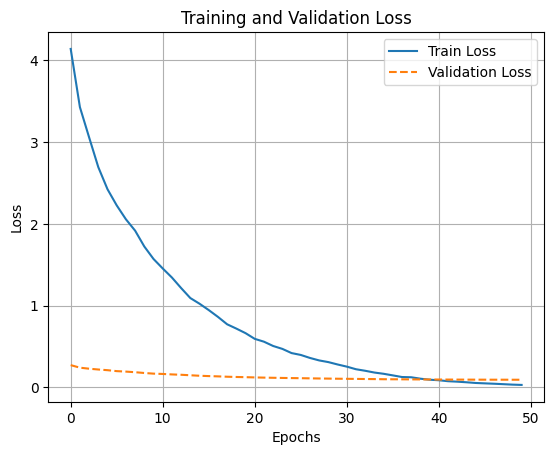

Validation MSE: 0.09492836147546768
Validation RMSE: 0.3081044554710388
Validation MAE: 0.22466787695884705
Validation R-squared: -0.9765440198696469
Validation Median Absolute Error: 0.1813586950302124


In [40]:
# Plotting training and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Print validation performance metrics
print(f"Validation MSE: {val_mse}")
print(f"Validation RMSE: {val_rmse}")
print(f"Validation MAE: {val_mae}")
print(f"Validation R-squared: {val_r2}")
print(f"Validation Median Absolute Error: {val_medae}")

# Inference

In [41]:
import joblib

# load in model from file
# inf_model_weights = torch.load("trained-full-dataset.pt", weights_only=True)
inf_model_weights = torch.load("trained-full-dataset-yield-density-no-leakage.pt", weights_only=True)
inf_model = HybridModel(CNNFeatureExtractor())
inf_model.load_state_dict(inf_model_weights)
inf_model.to(device)
inf_model.eval()

scaler = joblib.load("yield_scaler.save")

In [42]:

# inf_output = inf_model(evi_val, time_features_val)

# print(f"{evi_val.shape = }")
# print(f"{time_features_val.shape = }")
# print(f"{inf_output.shape = }")

In [43]:
yield_data_weekly.iloc[0].name

Timestamp('2012-03-04 00:00:00')

In [44]:

evi_data_dir = "./landsat_evi_monterey_masked"
dataset_loader, _, mean, std = prepare_dataset(evi_data_dir, yield_data_weekly, target_shape, augment=True, full=True)

Processed file 1/84 in 2.11s
Processed file 2/84 in 2.10s
Processed file 3/84 in 1.89s
Processed file 4/84 in 2.02s
Processed file 5/84 in 2.10s
Processed file 6/84 in 2.37s
Processed file 7/84 in 2.32s
Processed file 8/84 in 2.08s
Processed file 9/84 in 2.18s
Processed file 10/84 in 2.00s
Processed file 11/84 in 2.02s
Processed file 12/84 in 2.21s
Processed file 13/84 in 2.02s
Processed file 14/84 in 2.30s
Processed file 15/84 in 2.28s
Processed file 16/84 in 1.88s
Processed file 17/84 in 1.88s
Processed file 19/84 in 1.72s
Processed file 20/84 in 1.64s
Processed file 21/84 in 2.31s
Processed file 22/84 in 1.73s
Processed file 23/84 in 1.83s
Processed file 24/84 in 2.45s
Processed file 25/84 in 2.27s
Processed file 26/84 in 1.72s
Processed file 27/84 in 1.65s
Processed file 28/84 in 1.75s
Processed file 29/84 in 2.26s
Processed file 30/84 in 1.92s
Processed file 31/84 in 1.85s
Processed file 32/84 in 1.88s
Processed file 33/84 in 1.72s
Processed file 34/84 in 2.19s
Processed file 35/8

ValueError: too many values to unpack (expected 4)

In [ ]:
timestamps = torch.Tensor()
yield_labels = torch.Tensor()
predictions = torch.Tensor()

for idx, (inputs, labels, time_features, timestamp) in enumerate(dataset_loader):
    print(f"Running inference... {idx/len(dataset_loader)*100:.2f}%", end='\r')
    inputs, labels, time_features = inputs.to(device), labels.to(device), time_features.to(device)
    outputs = inf_model(inputs, time_features)
    summed_outputs = outputs.sum(dim=(1,2))

    if idx >0:
        break
    timestamps = torch.cat((timestamps, timestamp))
    yield_labels = torch.cat((yield_labels, labels.to("cpu")))
    predictions = torch.cat((predictions, summed_outputs.to("cpu")))

    # loss = criterion(outputs, labels)
    # val_loss += loss.item()

# val_loss /= len(val_loader)
# print(f'Validation Loss: {val_loss}')

In [ ]:
yield_labels.reshape(-1,1)

tensor([0.4385, 0.8434, 0.4935, 0.0000])

In [ ]:
scaler.inverse_transform(yield_labels.reshape(-1, 1))

array([[20429036.3072927 ],
       [39287413.27969694],
       [22990931.39602876],
       [       0.        ]])

In [ ]:
scaler.inverse_transform(predictions.detach().numpy().reshape(-1,1))

array([[1023663.94],
       [1020795.2 ],
       [1033442.56],
       [ 977205.5 ]], dtype=float32)

In [ ]:
yield_labels

tensor([0.4385, 0.8434, 0.4935, 0.0000])

In [ ]:
yield_data_weekly

,Volume (Pounds),Cumulative Volumne (Pounds),Pounds/Acre,month_sin,month_cos,day_of_year_sin,day_of_year_cos
Date,,,,,,,
2012-03-04,0.011286,1785843.0,18.333333,1.000000e+00,6.123234e-17,0.891981,0.452072
2012-03-11,0.063317,4735377.0,51.666667,1.000000e+00,6.123234e-17,0.939856,0.341571
2012-03-18,0.102446,9507645.0,83.500000,1.000000e+00,6.123234e-17,0.974100,0.226116
2012-03-25,0.067456,12649959.0,55.000000,1.000000e+00,6.123234e-17,0.994218,0.107381
2012-04-01,0.134627,18921357.0,93.857143,8.660254e-01,-5.000000e-01,0.999917,-0.012910
...,...,...,...,...,...,...,...
2024-05-12,0.767907,682790517.0,305.285714,5.000000e-01,-8.660254e-01,0.752667,-0.658402
2024-05-19,0.787426,682790517.0,365.166667,5.000000e-01,-8.660254e-01,0.668064,-0.744104
2024-05-26,0.827681,682790517.0,329.285714,5.000000e-01,-8.660254e-01,0.573772,-0.819015


In [ ]:
timestamps, yield_labels, predictions

In [ ]:
yield_data_weekly

In [ ]:
out_df = pd.DataFrame(data={"timestamp":timestamps.to_numpy(), "prediction":predictions.to_numpy(), "truth":yield_labels.to_numpy()})
out_df.to_csv("out.csv")